In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Stochastic Gradient Descent

In machine learning, and scientific machine learning in particular, we often have to train a model $f(x, \theta)$ by minimizing a loss function $L(\theta)$.
The loss function usually has the form (example from regression):

$$L(\theta) = \frac{1}{N} \sum_{i=1}^N l(f(x_i, \theta), y_i)$$

where $l$ is a loss function for a single data point, $x_i$ is the $i$-th data point, $y_i$ is the corresponding label, and $N$ is the number of data points.

The algorithms we have introduced so far, such as gradient descent, are called *batch* algorithms because they use all the data points to compute the gradient of the loss function.
This is not always feasible, especially when the data set is large.
So, we would like to develop algorithms that use only a subset of the data points to compute the gradient.
These algorithms are called *stochastic* algorithms or *minibatch* algorithms.
It turns out that stochastic algorithms are also inherently capable of escaping from bad local minima, which is a nice bonus.

The first and simplest stochastic algorithm is called *stochastic gradient descent* (SGD).
If we use a single data point to compute the gradient, the algorithm is called *pure* SGD or *online* SGD.
The algorithm is as follows:

1. Initialize $\theta_0$ to some random value.
2. For $t = 1, 2, \ldots$:
    1. Pick a random data point $(x_i, y_i)$.
    2. Compute the gradient of $l(f(x_i, \theta_t), y_i)$ with respect to $\theta_t$.
    3. Update $\theta_t$ by taking a step in the direction of the negative gradient with a learning rate of $\alpha$.

Typically, we go over the data set multiple times.
Each time we go over the data set is called an *epoch*.

Let's demonstrate this algorithm in a simple example.

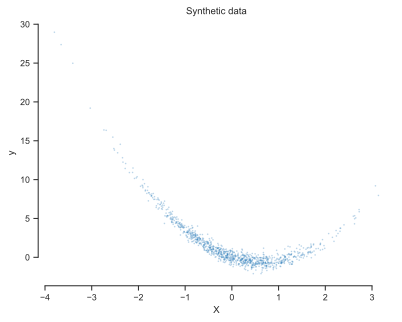

In [58]:
import jax.numpy as jnp
import jax.random as jrandom

key = jrandom.PRNGKey(0)

# Generate some synthetic data
N = 1_000
X = jrandom.normal(key, (N,))
key, subkey = jrandom.split(key)
y = 1.5 * X ** 2 - 2 * X + jrandom.normal(subkey, (N,)) * 0.5

# Make also a test set (here an ideal one)
N_test = 50
X_test = jnp.linspace(-3, 3, N_test)
key, subkey = jrandom.split(key)
y_test = 1.5 * X_test ** 2 - 2 * X_test + jrandom.normal(subkey, (N_test,)) * 0.5

# Visualize the training data
fig, ax = plt.subplots()
# Scatter with small size of points
ax.scatter(X, y, alpha=0.2, s=1)
ax.set(xlabel="X", ylabel="y", title="Synthetic data")
sns.despine(trim=True);

Let's make our model and our loss function.
We will use `Equinox` to make a simple quadratic model.
The reason I use `Equinox` is that is that you can practice a bit with it.

The model I will make is:

$$
f(x,\theta) = \theta_0 + \theta_1 x + \theta_2 x^2.
$$

In [59]:
import numpy as np
import equinox as eqx
import jax
import optax
from functools import partial


class MyModel(eqx.Module):
    theta: jax.Array

    def __init__(self, key):
        self.theta = jax.random.normal(key, (3,))
    
    @partial(jax.vmap, in_axes=(None, 0))
    def __call__(self, x):
        return self.theta @ jnp.array([1, x, x ** 2])
    

# Now we can make the train function.
def train_online(
        model,
        x, y,
        optimizer,
        x_test, y_test,
        n_epochs=10,
        freq=1,
    ):
    
    # This is the loss function
    @eqx.filter_jit
    def loss(model, x, y):
        y_pred = model(x)
        return optax.l2_loss(y_pred, y).mean()

    # This is the step of the optimizer. We **always** jit:
    @eqx.filter_jit
    def step(opt_state, model, xi, yi):
        value, grads = eqx.filter_value_and_grad(loss)(model, xi, yi)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    # The state of the optimizer
    opt_state = optimizer.init(model)
    # The path of the model
    path = []
    # The path of the test loss
    losses = []
    # The path of the test accuracy
    test_losses = []
    for e in range(n_epochs):
        for i in range(x.shape[0]):
            # We pick a random point
            # We don't need to use jax for this - numpy is fine
            j = np.random.randint(0, x.shape[0])
            xj, yj = x[j].ravel(), y[j].ravel()
            model, opt_state, value = step(opt_state, model, xj, yj)
            if i % freq == 0:
                path.append(model)
                losses.append(value)
                test_losses.append(loss(model, x_test, y_test))
                print(f"Epoch {e}, step {i}, loss {value:.3f}, test {test_losses[-1]:.3f}")
    return model, path, losses, test_losses

We can use the code above like this:

In [60]:
# Make the model
key, subkey = jrandom.split(key)
model = MyModel(subkey)

# Make the optimizer
optimizer = optax.sgd(learning_rate=0.01, momentum=0.5, nesterov=True)

# Train the model
model, path, losses, test_losses = train_online(
    model,
    X, y,
    optimizer,
    X_test, y_test,
    n_epochs=20,
)

Epoch 0, step 0, loss 10.891, test 51.632
Epoch 0, step 1, loss 164.751, test 3.478
Epoch 0, step 2, loss 2.830, test 1.130
Epoch 0, step 3, loss 2.336, test 0.716
Epoch 0, step 4, loss 2.217, test 0.706
Epoch 0, step 5, loss 0.072, test 0.775
Epoch 0, step 6, loss 0.297, test 0.818
Epoch 0, step 7, loss 3.237, test 0.974
Epoch 0, step 8, loss 1.047, test 0.672
Epoch 0, step 9, loss 1.944, test 0.635
Epoch 0, step 10, loss 0.121, test 0.622
Epoch 0, step 11, loss 0.227, test 0.644
Epoch 0, step 12, loss 0.126, test 0.644
Epoch 0, step 13, loss 0.066, test 0.657
Epoch 0, step 14, loss 1.993, test 0.667
Epoch 0, step 15, loss 0.355, test 0.671
Epoch 0, step 16, loss 1.279, test 0.799
Epoch 0, step 17, loss 0.801, test 0.945
Epoch 0, step 18, loss 0.001, test 0.989
Epoch 0, step 19, loss 1.225, test 0.585
Epoch 0, step 20, loss 0.249, test 0.545
Epoch 0, step 21, loss 0.092, test 0.557
Epoch 0, step 22, loss 0.424, test 0.579
Epoch 0, step 23, loss 0.521, test 0.579
Epoch 0, step 24, loss

Let's inspect what is happening here.
First, let's plot the parameters $\theta$.

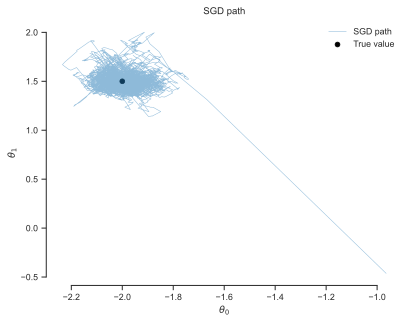

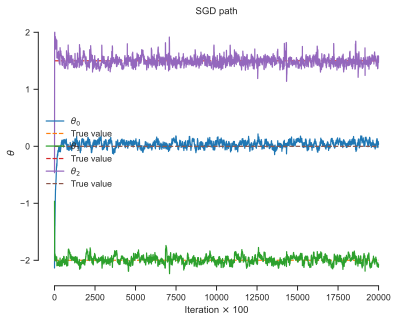

In [61]:
# With this we can get all the parameters in an array
thetas = np.array(jax.tree_util.tree_leaves(path))

# 2D plot of the parameters evolution
fig, ax = plt.subplots()
ax.plot(thetas[:, 1], thetas[:, 2], alpha=0.5, lw=0.5, label="SGD path")
# Correct values
ax.scatter([-2], [1.5], marker="o", color="black", label="True value")
ax.set(xlabel=r"$\theta_0$", ylabel=r"$\theta_1$", title="SGD path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# Parameters per iteration
fig, ax = plt.subplots()
ax.plot(thetas[:, 0], label=r"$\theta_0$")
ax.plot([-2] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 1], label=r"$\theta_1$")
ax.plot([1.5] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 2], label=r"$\theta_2$")
ax.plot([0] * thetas.shape[0], '--', label="True value")
ax.set(xlabel="Iteration $\\times$ 100", ylabel=r"$\theta$", title="SGD path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

We see that the parameters do move towards the correct values but it doesn't converge.
They wiggle around the correct values.

Let's look at the loss as well:

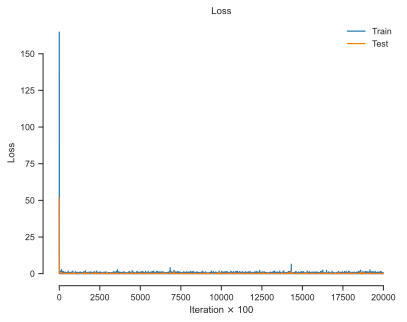

In [62]:
fig, ax = plt.subplots()
ax.plot(losses, label="Train")
ax.plot(test_losses, label="Test")
ax.set(xlabel="Iteration $\\times$ 100", ylabel="Loss", title="Loss")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

To make SGD converge, we need to use a decaying learning rate.
Theoretically, the learning rate needs to satisfy the Robbins-Monro conditions:

$$
\sum_{t=1}^\infty \alpha_t = \infty \quad \text{and} \quad \sum_{t=1}^\infty \alpha_t^2 < \infty.
$$

This means that the learning rate needs to decay to zero but not too fast.
In practice, we are not really going to bother enforcing the condition.
We just need something that decays.

In [73]:
# A new model to start from scratch
key, subkey = jrandom.split(key)
model = MyModel(subkey)

learning_rate_schedule = optax.exponential_decay(0.01, 20 * N, 0.01)
optimizer = optax.sgd(learning_rate=learning_rate_schedule, momentum=0.5, nesterov=True)

Before we train, let's see how the learning rate changes over time:

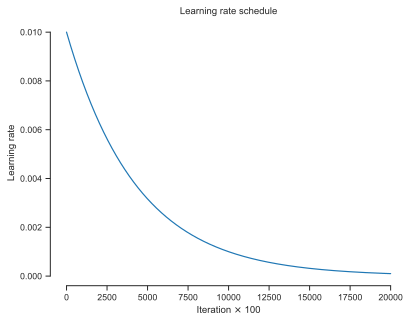

In [74]:
fig, ax = plt.subplots()
iterations = np.arange(20 * N)
ax.plot(iterations, learning_rate_schedule(iterations))
ax.set(xlabel="Iteration $\\times$ 100", ylabel="Learning rate", title="Learning rate schedule")
sns.despine(trim=True);

Of course, this is kind of arbitrary at this point.

In [75]:
model, path, losses, test_losses = train_online(
    model,
    X, y,
    optimizer,
    X_test, y_test,
    n_epochs=20,
)

Epoch 0, step 0, loss 0.274, test 70.417
Epoch 0, step 1, loss 3.078, test 69.315
Epoch 0, step 2, loss 8.955, test 66.495
Epoch 0, step 3, loss 1.464, test 66.569
Epoch 0, step 4, loss 22.827, test 58.563
Epoch 0, step 5, loss 37.208, test 46.084
Epoch 0, step 6, loss 0.018, test 43.889
Epoch 0, step 7, loss 1.097, test 42.894
Epoch 0, step 8, loss 1.006, test 42.616
Epoch 0, step 9, loss 1.675, test 41.861
Epoch 0, step 10, loss 0.006, test 41.677
Epoch 0, step 11, loss 1.452, test 42.145
Epoch 0, step 12, loss 0.000, test 42.183
Epoch 0, step 13, loss 0.550, test 42.455
Epoch 0, step 14, loss 22.786, test 34.452
Epoch 0, step 15, loss 0.816, test 33.309
Epoch 0, step 16, loss 2.285, test 31.817
Epoch 0, step 17, loss 0.130, test 30.802
Epoch 0, step 18, loss 2.966, test 29.497
Epoch 0, step 19, loss 12.788, test 24.334
Epoch 0, step 20, loss 0.207, test 23.483
Epoch 0, step 21, loss 0.816, test 22.766
Epoch 0, step 22, loss 1.196, test 22.016
Epoch 0, step 23, loss 0.321, test 21.85

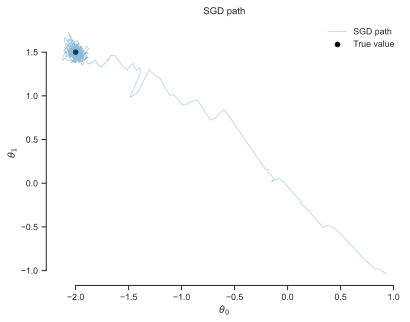

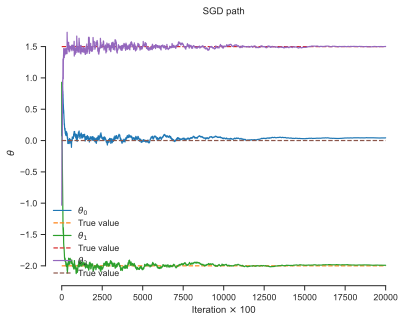

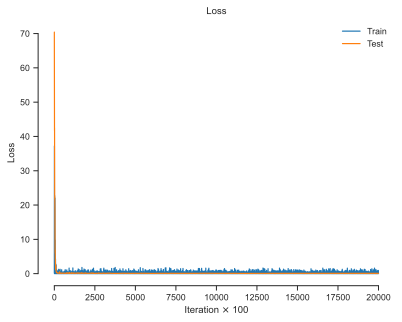

In [77]:
thetas = np.array(jax.tree_util.tree_leaves(path))

# 2D plot of the parameters evolution
fig, ax = plt.subplots()
ax.plot(thetas[:, 1], thetas[:, 2], alpha=0.5, lw=0.5, label="SGD path")
# Correct values
ax.scatter([-2], [1.5], marker="o", color="black", label="True value")
ax.set(xlabel=r"$\theta_0$", ylabel=r"$\theta_1$", title="SGD path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# Parameters per iteration
fig, ax = plt.subplots()
ax.plot(thetas[:, 0], label=r"$\theta_0$")
ax.plot([-2] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 1], label=r"$\theta_1$")
ax.plot([1.5] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 2], label=r"$\theta_2$")
ax.plot([0] * thetas.shape[0], '--', label="True value")
ax.set(xlabel="Iteration $\\times$ 100", ylabel=r"$\theta$", title="SGD path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# The losses
fig, ax = plt.subplots()
ax.plot(losses, label="Train")
ax.plot(test_losses, label="Test")
ax.set(xlabel="Iteration $\\times$ 100", ylabel="Loss", title="Loss")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Mini batch SGD

Now let's do the same thing with mini batches of data.
Suppose we have a data set of size $N$ and we want to use a mini batch size of $M$.
Then, our update rule becomes:

$$
\theta_{t+1} = \theta_t - \alpha_t \frac{1}{M} \sum_{i=1}^M \nabla_\theta l(f(x_i, \theta_t), y_i).
$$

There are two main reasons why we use mini batches:

1. It is more efficient to compute the gradient of a mini batch than the gradient of a single data point. This is because we can use vectorized operations.

2. A bigger mini batch size leads to a more accurate estimate of the gradient than a smaller mini batch size.

Of course, there is also a sweet spot. Too big mini batches can lead to bad local minima. Too small mini batches can lead to noisy gradients.

Let's see how we can do it.
We need to modify our training routine a bit.

In [78]:
# The function below generates batches of data
def data_generator(X, y, batch_size, shuffle=True):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

def train_batch(
        model,
        x, y,
        optimizer,
        x_test, y_test,
        n_batch=10,
        n_epochs=10,
        freq=1,
    ):
    
    # This is the loss function
    @eqx.filter_jit
    def loss(model, x, y):
        y_pred = model(x)
        return optax.l2_loss(y_pred, y).mean()

    # This is the step of the optimizer. We **always** jit:
    @eqx.filter_jit
    def step(opt_state, model, xi, yi):
        value, grads = eqx.filter_value_and_grad(loss)(model, xi, yi)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    # The state of the optimizer
    opt_state = optimizer.init(model)
    # The path of the model
    path = []
    # The path of the test loss
    losses = []
    # The path of the test accuracy
    test_losses = []
    for e in range(n_epochs):
        for i, (xb, yb) in enumerate(data_generator(x, y, n_batch)):
            model, opt_state, value = step(opt_state, model, xb, yb)
            if i % freq == 0:
                path.append(model)
                losses.append(value)
                test_losses.append(loss(model, x_test, y_test))
                print(f"Epoch {e}, step {i}, loss {value:.3f}, test {test_losses[-1]:.3f}")
    return model, path, losses, test_losses

Let's train. We will do more epochs this time because we are doing less updates per epoch. And we also adjust the learning rate a bit.

In [92]:
key, subkey = jrandom.split(key)
model = MyModel(subkey)

learning_rate_schedule = optax.exponential_decay(0.01, 50 * N/10, 0.01)
optimizer = optax.sgd(learning_rate=learning_rate_schedule, momentum=0.5, nesterov=True)

model, path, losses, test_losses = train_batch(
    model,
    X, y,
    optimizer,
    X_test, y_test,
    n_batch=10,
    n_epochs=50,
)

Epoch 0, step 0, loss 5.706, test 48.438
Epoch 0, step 1, loss 13.422, test 40.725
Epoch 0, step 2, loss 7.715, test 35.770
Epoch 0, step 3, loss 7.017, test 31.115
Epoch 0, step 4, loss 3.817, test 28.479
Epoch 0, step 5, loss 0.353, test 27.438
Epoch 0, step 6, loss 2.655, test 26.072
Epoch 0, step 7, loss 5.929, test 23.228
Epoch 0, step 8, loss 7.413, test 19.540
Epoch 0, step 9, loss 0.551, test 18.658
Epoch 0, step 10, loss 2.952, test 16.326
Epoch 0, step 11, loss 5.973, test 13.492
Epoch 0, step 12, loss 2.283, test 12.217
Epoch 0, step 13, loss 6.007, test 9.356
Epoch 0, step 14, loss 0.501, test 8.709
Epoch 0, step 15, loss 0.190, test 8.335
Epoch 0, step 16, loss 0.563, test 8.019
Epoch 0, step 17, loss 0.168, test 7.891
Epoch 0, step 18, loss 1.420, test 7.413
Epoch 0, step 19, loss 3.310, test 5.805
Epoch 0, step 20, loss 2.166, test 4.875
Epoch 0, step 21, loss 6.137, test 2.811
Epoch 0, step 22, loss 0.944, test 2.216
Epoch 0, step 23, loss 0.709, test 1.942
Epoch 0, ste

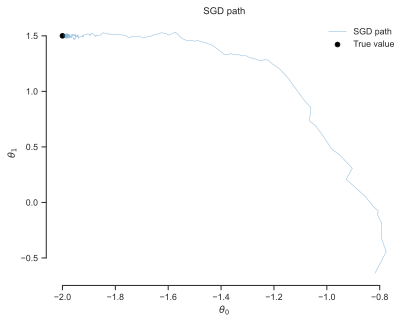

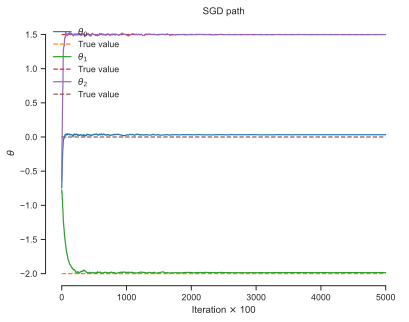

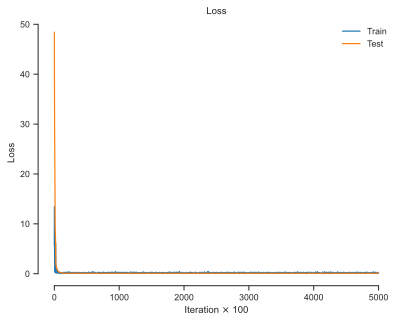

In [94]:
thetas = np.array(jax.tree_util.tree_leaves(path))

# 2D plot of the parameters evolution
fig, ax = plt.subplots()
ax.plot(thetas[:, 1], thetas[:, 2], alpha=0.5, lw=0.5, label="SGD path")
# Correct values
ax.scatter([-2], [1.5], marker="o", color="black", label="True value")
ax.set(xlabel=r"$\theta_0$", ylabel=r"$\theta_1$", title="SGD path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# Parameters per iteration
fig, ax = plt.subplots()
ax.plot(thetas[:, 0], label=r"$\theta_0$")
ax.plot([-2] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 1], label=r"$\theta_1$")
ax.plot([1.5] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 2], label=r"$\theta_2$")
ax.plot([0] * thetas.shape[0], '--', label="True value")
ax.set(xlabel="Iteration $\\times$ 100", ylabel=r"$\theta$", title="SGD path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# The losses
fig, ax = plt.subplots()
ax.plot(losses, label="Train")
ax.plot(test_losses, label="Test")
ax.set(xlabel="Iteration $\\times$ 100", ylabel="Loss", title="Loss")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);